In [128]:
from  snippets.reader  import *
from snippets.transform import *
from snippets.vectorization import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# テキストの読み込み

In [129]:
natume=JapaneseCorpusReader('./dataset/corpas/natsume/',encoding='shift_jis')
dazai=JapaneseCorpusReader('./dataset/corpas/dazai/',encoding='shift_jis')

# 規格化

In [130]:
nomalizer=JapaneseTextNormalizer()
natume_normed=nomalizer.transform(natume,['助詞', '助動詞', '記号','動詞'])
dazai_normed=nomalizer.transform(dazai,['助詞', '助動詞', '記号','動詞'])

In [131]:
# 正解ラベルを作成
target=np.hstack((np.zeros(len(natume_normed)),np.ones(len(dazai_normed))))
target[:len(natume_normed)+1]

array([0., 0., 0., ..., 0., 0., 1.])

4098

In [132]:
len(target)

6567

# 可視化

### 頻度分布

In [133]:
natume_word=pd.Series(sum(natume_normed,[]))
dazai_word=pd.Series(sum(dazai_normed,[]))

In [146]:
natume_count=natume_word.value_counts()
natume_count.head(20)

おれ     447
の      343
ない     265
事      260
もの     205
ん      199
人      199
赤      162
お      162
よう     160
一      159
そう     155
シャツ    154
山嵐     148
君      144
この     135
何      132
二      111
時      101
方      100
dtype: int64

In [147]:
dazai_count=dazai_word.value_counts()
dazai_count.head(20)

の     951
自分    668
僕     560
事     468
その    428
よう    424
もの    333
それ    288
さん    275
お     261
ん     248
この    228
たち    224
人     212
無い    203
竹     183
坊     177
マア    177
そう    171
また    168
dtype: int64

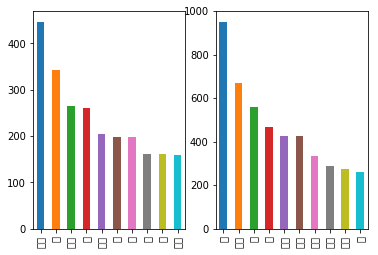

In [86]:
fig,(ax1,ax2)=plt.subplots(1,2)
natume_count.head(10).plot.bar(ax=ax1)
dazai_count.head(10).plot.bar(ax=ax2)

## それぞれの作品に特徴的な言葉を見つける

In [125]:
dazai_word_set=set(dazai_word)
natume_word_set=set(natume_word)


### 太宰しかでてない言葉の頻度分布


In [126]:
# 差集合を取る
only_dazai=dazai_word_set.difference(natume_word_set)
dazai_count.loc[only_dazai].sort_values(ascending=False).head(20)


マア      177
気持       78
みたい      76
堀木       73
わけ       72
道場       72
けれども     64
ひばり      50
父        48
ヒラメ      47
助手       45
固い       41
道化       39
ベッド      39
塾生       38
摩擦       36
つくし      35
口調       31
パン       31
或        30
dtype: int64

## 夏目漱石しか出ていない言葉の頻度分布

In [127]:
# 差集合を取る
only_natsume=natume_word_set.difference(dazai_word_set)
natume_count.loc[only_natsume].sort_values(ascending=False).head(20)


シャツ     154
山嵐      148
校長       59
狸        34
教頭       31
驚        25
マドンナ     23
古賀       22
団子       22
今度       21
芸者       20
分        20
相違       20
込        18
婆さん      18
るい       18
厘        18
バッタ      18
大分       18
いっしょ     18
dtype: int64

# ベクトル化

## tf_idf


In [12]:
tfidf=TfidfVectorizer()

In [57]:
## 全データを結合
all_data=dazai_normed+natume_normed
# 変換
all_data=tfidf.transform(all_data)
all_data=pd.DataFrame(all_data).fillna(0)
all_data=all_data.to_sparse(fill_value=0)


In [58]:
all_data.head()

,-,.,/）,1,10,13,1945,1946,1948,1999,...,鼠,鼠小僧次郎吉,鼻,鼻つまみ,鼻柱,鼻緒,＃,２,ＤＩＡＬ,Ｐ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  targetを作成

In [60]:
target_df=pd.Series(target)
target_df.name='target'

# モデルに適用

## データの分割

In [62]:
x_train,x_test,t_train,t_test=train_test_split(all_data,target_df,random_state=1)

In [63]:
model=LogisticRegression()
model.fit(x_train,t_train)
pred=model.predict(x_test)

# 評価

In [65]:
print(classification_report(t_test,pred))

             precision    recall  f1-score   support

        0.0       0.73      0.66      0.69       603
        1.0       0.81      0.86      0.83      1039

avg / total       0.78      0.78      0.78      1642

